In [1]:
import numpy as np
import imageio.v3 as iio
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Load a random image from the web
im = iio.imread('https://picsum.photos/id/292/500')

In [3]:
im.shape

(500, 500, 3)

In [4]:
# Red channel
red = im[:, :, 0]
# Green channel
green = im[:, :, 1]
# Blue channel
blue = im[:, :, 2]


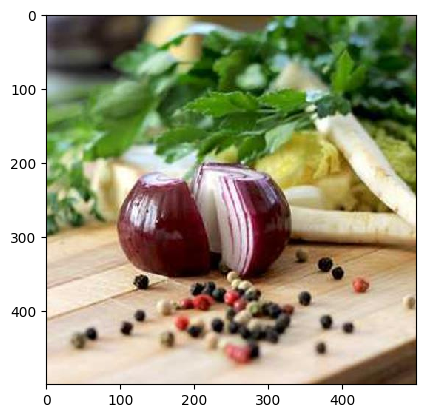

In [5]:
plt.figure()
plt.imshow(im, cmap='gray')

In [6]:
# Equivalent to img = (red + green + blue)/3.
img = im.mean(axis=-1)

In [7]:
img.shape

(500, 500)

In [8]:
# im is usigned 8-bit int
im.dtype

dtype('uint8')

In [9]:
# img is "double float"
img.dtype

dtype('float64')

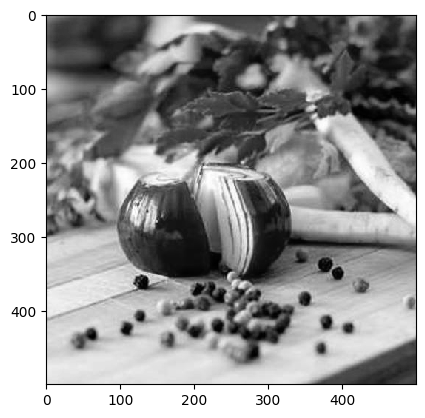

In [10]:
plt.figure()
plt.imshow(img, cmap='gray')


In [11]:
# Select ROI
ROI = img[347:377, 112:147]

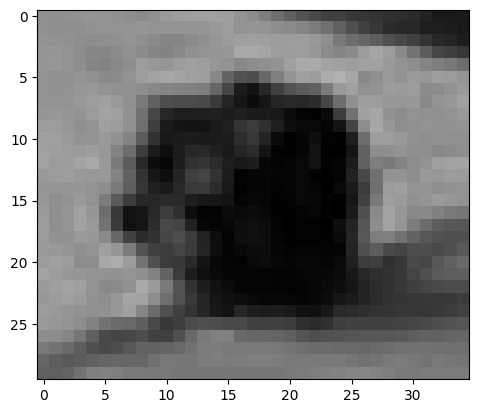

In [12]:
plt.figure()
plt.imshow(ROI, cmap='gray', vmin=0, vmax=350)

In [13]:
ROI += 100

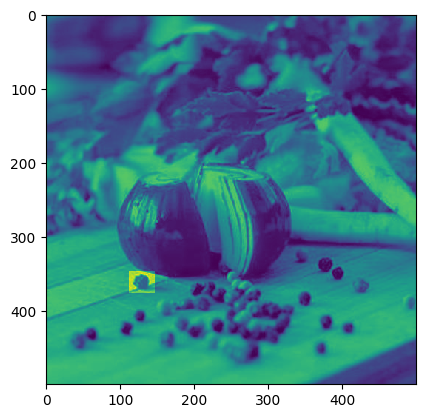

In [14]:
plt.figure()
plt.imshow(img)

In [15]:
ROI.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [16]:
# If you want a copy
ROI = img[347:377, 112:147].copy()
ROI = 1. * img[347:377, 112:147]
ROI = 0 + img[347:377, 112:147]

In [17]:
ROI.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [18]:
# Horizontal profile
xprofile = img[280, :]

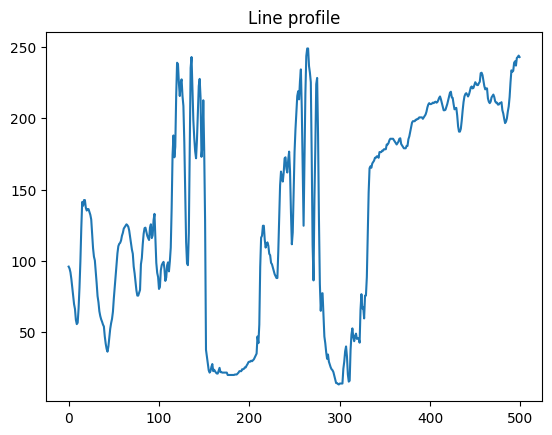

In [19]:
plt.figure()
plt.plot(xprofile)
plt.title('Line profile');

### Example of intensity transform: contrast applied on original uint8 image

Watch out: conversion from float to unsigned 8-bit int wraps around the integer part. This is why we need to use `numpy.clip` first

In [20]:
np.array([-3. , 10, 200, 300.]).astype('uint8')

array([253,  10, 200,  44], dtype=uint8)

In [21]:
C = 2.
out = np.clip(127 + C*(im.astype(float)-127), 0, 255).astype('uint8')

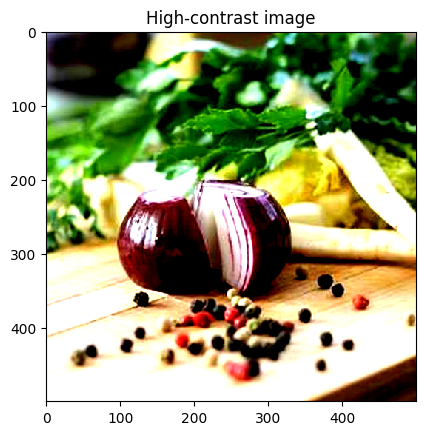

In [22]:
plt.figure()
plt.imshow(out)
plt.title('High-contrast image');

Becaus of the relatively small dynamic range of `uint8` type, stretching the contrast leads to over- and underflows. We can find the overflow pixels looking to those with RGB values of (0,0,0) or (255,255,255):

In [23]:
underflow = np.all(out == 0, axis=-1)
overflow = np.all(out==255, axis=-1)

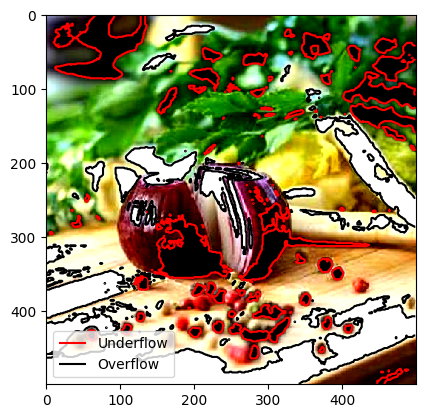

In [24]:
plt.figure()
plt.imshow(out)
c0 = plt.contour(underflow.astype(float), levels=[.5], colors=['red'])
c1 = plt.contour(overflow.astype(float), levels=[.5], colors=['black'])
h0 = c0.legend_elements()[0]
h1 = c1.legend_elements()[0]

plt.legend(c0.legend_elements()[0] + c1.legend_elements()[0], ['Underflow', 'Overflow'], loc='lower left');

### Elementary binary operations

(-0.5, 199.5, 199.5, -0.5)

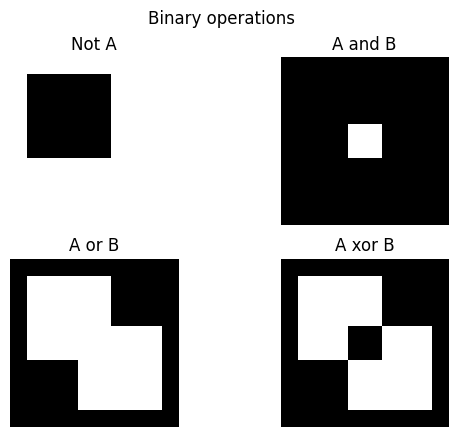

In [25]:
A = np.zeros((200, 200), dtype=bool)
B = np.zeros_like(A)
A[20:120,20:120] = True
B[-120:-20, -120:-20] = True

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.suptitle('Binary operations')

# not
ax1.imshow(~A, cmap='gray')
ax1.set_title('Not A')
ax1.axis('off')

# and
ax2.imshow(A & B, cmap='gray')
ax2.set_title('A and B')
ax2.axis('off')

# or
ax3.imshow(A | B, cmap='gray')
ax3.set_title('A or B')
ax3.axis('off')

# xor
ax4.imshow((A & ~B) | (B & ~A), cmap='gray')
ax4.set_title('A xor B');
ax4.axis('off')


### Creating a circular mask

In [26]:
N = 15

# Slower approach: an explicit loop
radius = (N-1)//2
mask = np.zeros((N, N), dtype=bool)
for i in range(N):
    for j in range(N):
        dst2 = (i-radius)**2 + (j-radius)**2
        mask[i, j] = (dst2 <= radius**2)

# Vectorized operations on numpy arrays
ii, jj = np.indices((N, N))
dst2 = (ii-radius)**2 + (jj-radius)**2
mask = (dst2 <= radius**2)

# One-liner
mask = (((np.indices((N, N)) - radius)**2).sum(axis=0) <= radius**2)

### Applying opening morphological operation

In [28]:
import scipy
N = 7
mask = (((np.indices((N, N)) - radius)**2).sum(axis=0) <= radius**2)
underflow_closed = scipy.ndimage.binary_opening(underflow, structure=mask)

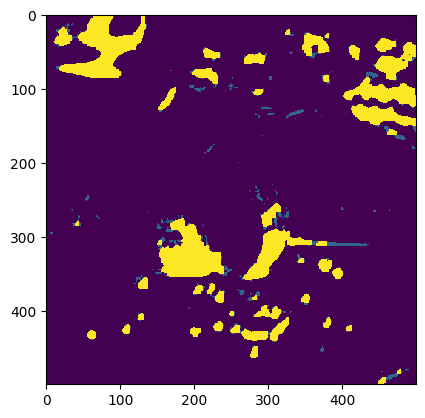

In [29]:
plt.figure()
plt.imshow(underflow + 2*underflow_closed)